In [105]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import patsy
import warnings
from scipy.stats.contingency import association
from scipy.stats import contingency
import missingno as msno
import sklearn.impute as skl_imp
from sklearn.experimental import enable_iterative_imputer
import feature_engine.imputation as fe_imp
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import scale
from statsmodels.graphics.factorplots import interaction_plot
import plotly.express as px

def cross_val_lin(formula:str, data:pd.DataFrame, seed=1):
    y, x = patsy.dmatrices(formula, data, return_type='dataframe')
    model = LinearRegression()
    # Establecemos esquema de validación fijando random_state 
    cv = RepeatedKFold(n_splits=5, n_repeats=20, random_state=seed)
    # Obtenemos los resultados de r2 para cada partici[on training-test
    scores = cross_val_score(model, x, y, cv=cv)
    
    # Sesgo y varianz
    print('Modelo:' + str(formula)) 
    print("Coeficiente de determinacion R2: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))
    return scores

def ols_formula(df, dependent_var, *excluded_cols):
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    for col in excluded_cols:
        df_columns.remove(col)
    return dependent_var + ' ~ ' + ' + '.join(df_columns)

def cat_plot(col):
    if col.dtypes == "category":
        fig = px.bar(col.value_counts())
        return fig
    
def plot(col):
    if col.dtypes != "category":
        histogram_boxplot(col, xlabel=col.name, title="Distribucion Continua")
    else:
        cat_plot(col)
    
def histogram_boxplot(data, xlabel= None, title = None, font_scale=2, figsize=(9,8), bins=None):
    sns.set(font_scale=font_scale)
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, 
                                           figsize=figsize)
    sns.boxplot(x=data, ax=ax_box2)

    sns.histplot(x=data, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=data, ax=ax_hist2)

    ax_hist2.axvline(np.mean(data), color='g', linestyle='-')

    ax_hist2.axvline(np.median(data), color='y', linestyle='--')

    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title, xlabel="")

    plt.show()
    
# Función para calcular VCramer (dos nominales de entrada!)
def cramers_v(var1, varObj):
    
    if not var1.dtypes == 'category':
        #bins = min(5,var1.value_counts().count())
        var1 = pd.cut(var1, bins = 5)
    if not varObj.dtypes == 'category': #np.issubdtype(varObj, np.number):
        #bins = min(5,varObj.value_counts().count())
        varObj = pd.cut(varObj, bins = 5)
        
    data = pd.crosstab(var1, varObj).values
    vCramer = stats.contingency.association(data, method = 'cramer')
    return vCramer
    
def mean_absolute_deviation(series):
    return (series - series.mean()).abs().mean()

## Función manual de winsor con clip+quantile 
def winsorize_with_pandas(s, limits):
    """
    s : pd.Series
        Series to winsorize
    limits : tuple of float
        Tuple of the percentages to cut on each side of the array, 
        with respect to the number of unmasked data, as floats between 0. and 1
    """
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'), 
                  upper=s.quantile(1-limits[1], interpolation='higher'))
## Función para gestionar outliers
def gestiona_outliers(col,clas = 'check'):

    print(col.name)
    # Condición de asimetría y aplicación de criterio 1 según el caso
    if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std())>3
    else:
        criterio1 = abs((col-col.median())/ mean_absolute_deviation(col)) > 8

    # Calcular primer cuartil     
    q1 = col.quantile(0.25)  
    # Calcular tercer cuartil  
    q3 = col.quantile(0.75)
    # Calculo de IQR
    IQR=q3-q1
    # Calcular criterio 2 (general para cualquier asimetría)
    criterio2 = (col<(q1 - 3*IQR))|(col>(q3 + 3*IQR))
    lower = col[criterio1&criterio2&(col<q1)].count()/col.dropna().count()
    upper = col[criterio1&criterio2&(col>q3)].count()/col.dropna().count()
    # Salida según el tipo deseado
    if clas == 'check':
        return(lower*100,upper*100,(lower+upper)*100)
    elif clas == 'winsor':
        return(winsorize_with_pandas(col,(lower,upper)))
    elif clas == 'miss':
        print('\n MissingAntes: ' + str(col.isna().sum()))
        col.loc[criterio1&criterio2] = np.nan
        print('MissingDespues: ' + str(col.isna().sum()) +'\n')
    return(col)

def mejorTransf (vv,target, name=False, tipo = 'cramer', graf=False):
    
    # Escalado de datos (evitar fallos de tamaño de float64 al hacer exp de número grande..cosas de python)
    vv = pd.Series(scale(vv), name=vv.name)
    # Traslación a valores positivos de la variable (sino falla log y las raíces!)
    vv = vv + abs(min(vv))+0.0001
      
    # Definimos y calculamos las transformaciones típicas  
    transf = pd.DataFrame({vv.name + '_ident': vv, vv.name + '_log': np.log(vv), vv.name + '_exp': np.exp(vv), vv.name + '_sqrt': np.sqrt(vv), 
                         vv.name + '_sqr': np.square(vv), vv.name + '_cuarta': vv**4, vv.name + '_raiz4': vv**(1/4)})
      
    # Distinguimos caso cramer o caso correlación
    if tipo == 'cramer':
      # Aplicar la función cramers_v a cada transformación frente a la respuesta
        tablaCramer = pd.DataFrame(transf.apply(lambda x: cramers_v(x,target)),columns=['VCramer'])
      
      # Si queremos gráfico, muestra comparativa entre las posibilidades
        if graf: px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente a ' + target.name).update_yaxes(categoryorder="total ascending").show()
      # Identificar mejor transformación
        best = tablaCramer.query('VCramer == VCramer.max()').index
        ser = transf[best[0]].squeeze()
    
    if tipo == 'cor':
      # Aplicar coeficiente de correlación a cada transformación frente a la respuesta
        tablaCorr = pd.DataFrame(transf.apply(lambda x: np.corrcoef(x,target)[0,1]),columns=['Corr'])
      # Si queremos gráfico, muestra comparativa entre las posibilidades
        if graf: px.bar(tablaCorr,x=tablaCorr.Corr,title='Relaciones frente a ' + target.name).update_yaxes(categoryorder="total ascending").show()
      # identificar mejor transformación
        best = tablaCorr.query('Corr.abs() == Corr.abs().max()').index
        ser = transf[best[0]].squeeze()
  
    # Aquí distingue si se devuelve la variable transformada o solamente el nombre de la transformación
    if name:
        return(ser.name)
    else:
        return(ser)


In [106]:
datos = pd.read_csv("DatosVinoDep_winsRand.csv")
datos.head(2)

,Unnamed: 0,ID,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,CalifProductor,PrecioBotella,Etiqueta,Clasificacion,Region,prop_missings,Beneficio,Compra
0,0,2.0,0.16,-0.81,26.1,-0.425,1.02792,3.38,0.70,10.5,2.0,1.00,M,***,1.0,0.015711,515,1
1,1,4.0,2.64,-0.88,14.8,0.037,0.99518,3.12,0.48,22.0,3.0,3.38,M,***,3.0,0.000000,585,1


Dado que vamos a evaluar las relaciones entre los predictores y la respuesta para conseguir linealidad, lo mejor es separar <br>
las respuestas y quedarnos con el input depurado, de esta forma podemos aplicar una misma función a todo el conjunto sin <br>
peligro de transformar las respuestas.

In [107]:
to_factor = list(datos.loc[:, datos.nunique() < 10]);
datos[to_factor] = datos[to_factor].astype("category")

datos["Etiqueta"] = datos["Etiqueta"].cat.reorder_categories(["MM", "M", "R", "B", "MB"])
datos["Clasificación"] = datos["Clasificacion"].cat.reorder_categories(["Desc", "*", "**", "***", "****"])

## Variables Control
Es una buena idea generar variables "Control" para la evaluación de los efectos de los predictores frente a la respuesta <br>
La idea es la siguiente: si generamos variables en el más estricto sentido aleatorio (por ejemplo siguiendo una distribución <br>
uniforme) cualquier relación que estas presenten con la variable respuesta serán debidas puramente al azar, con lo que se pueden <br>
considerar relaciones espurias, es decir, falsas.
<br>
<br>
Por tatno, ya se la inspección preliminar de relaciones con la respuesta mediante correlación (relación lineal, válido para <br>
continua-continua) o VCramer (Asociación de tablas de contingencia, válido para cruce de variables categóricas/nominal o <br>
continuas tramificadas)o bien en los propios modelos de regresión, las variables que presenten una menor relación con la <br>
respuesta que las variables control, tendán una sombra de sospecha sobre la veracidad de esa relación y serán descartadas. <br>


In [108]:
datos["Aleatorio 1"] = np.random.uniform(0, 1, size=datos.shape[0])
datos["Aleatorio 2"] = np.random.uniform(0, 1, size=datos.shape[0])
# Variable a modelar
variable_objetivo = datos["Compra"]
# Eliminar variables relacionadas con la compra
datos_backup = datos.copy()
datos = datos.drop(["ID", "Beneficio", "Compra"], axis=1)

## Estudio descriptivo de relaciones con la respuesta
Intentaremos descubrir a priori las relaciones marginales de las variables con la variable objetivo <br>
binaria para hacernos una idea de cuales de ellas serán potencialmente influyentes en los modelos <br>
de regresión logística que ajustemos

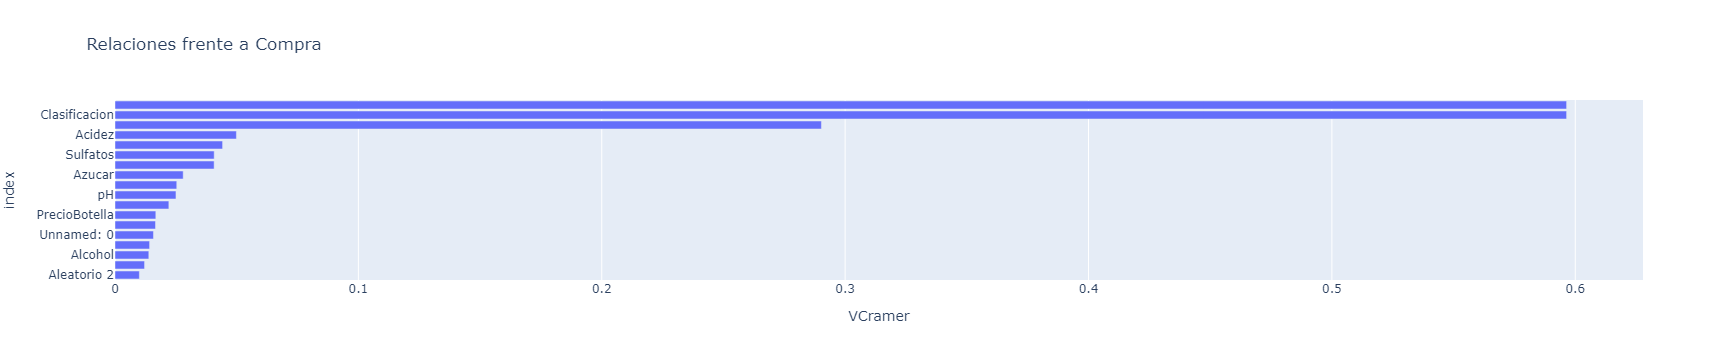

In [109]:
tablaCramer = pd.DataFrame(datos.apply(lambda x: cramers_v(x, variable_objetivo)), columns=["VCramer"])
px.bar(tablaCramer, x=tablaCramer["VCramer"], title="Relaciones frente a Compra").update_yaxes(categoryorder="total ascending").show()

En este caso tenemos que las variables tentativas para el modelado son:
- Clasificación
- Calificación del producto
- pH
- CloruroSodico
- Sulfatos
- Acidez

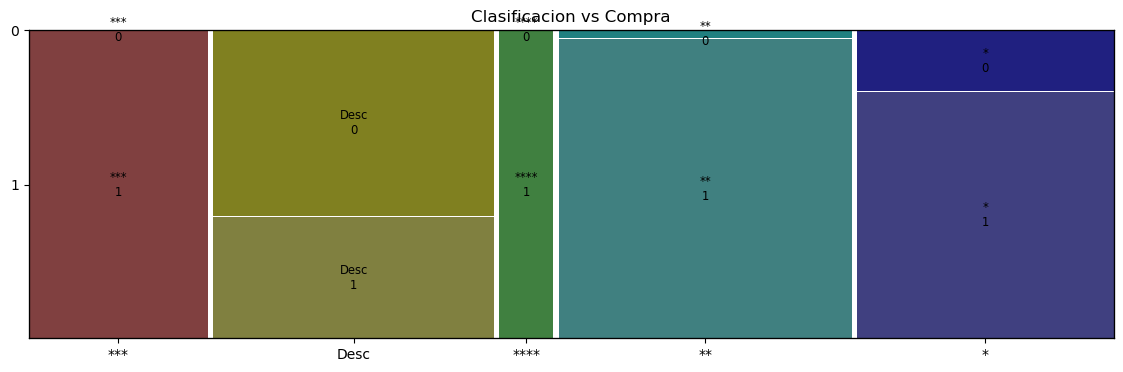

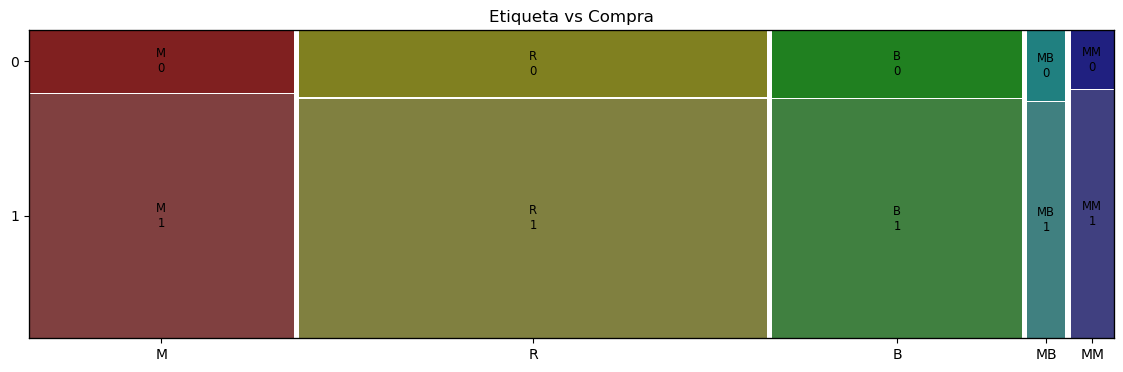

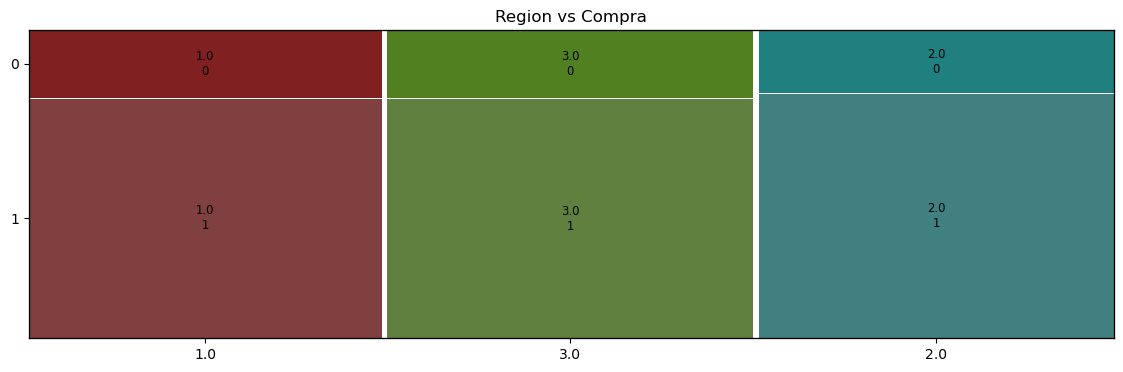

In [111]:
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

plt.rcParams['figure.figsize'] = [14, 4]  

mosaic(datos_backup, ['Clasificacion', 'Compra'], gap=0.005, title="Clasificacion vs Compra")
plt.show() 

mosaic(datos_backup, ['Etiqueta', 'Compra'], gap=0.005, title="Etiqueta vs Compra")
plt.show() 

mosaic(datos_backup, ['Region', 'Compra'], gap=0.005, title="Region vs Compra")
plt.show() 


La variable región es inutil para modelar la compra del bino ya que las distribuciones de 0 y 1 en las distintas regiones son muy similares <br>
En cambio la variable clasificación tiene mucho que aportar ya que hay grandes diferencias entre clasificaciones. Así, empezamos a intuir <br>
que los vinos con clasifiación desconocidas parecen no comprarse con la misma frequencia. Además parece existir una relación creciente <br>
de proporción de compro con el aumento de las estrellas de clasificación.

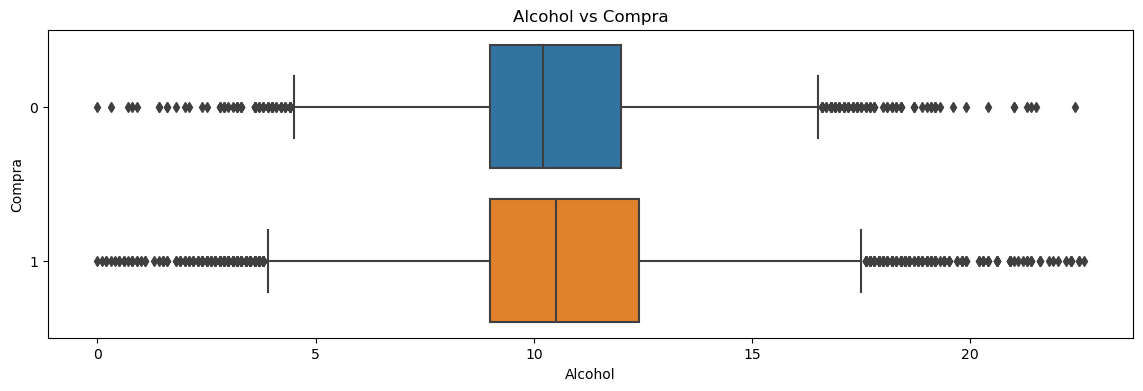

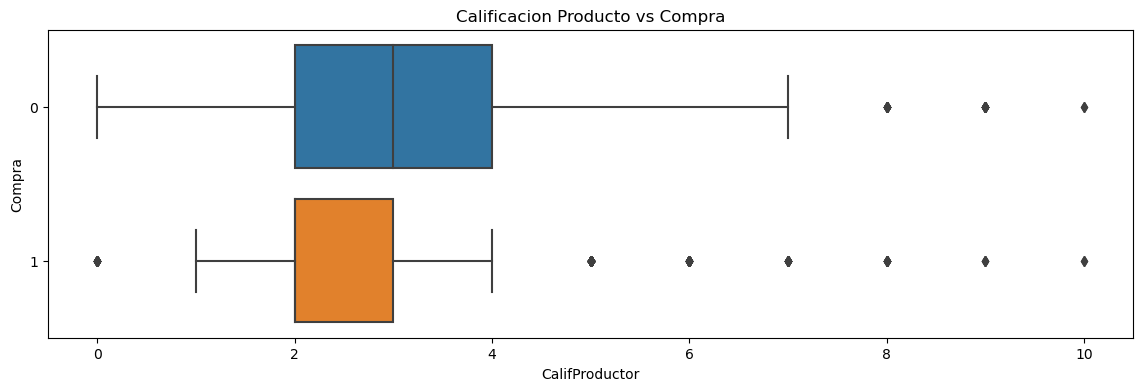

<Figure size 1400x400 with 0 Axes>

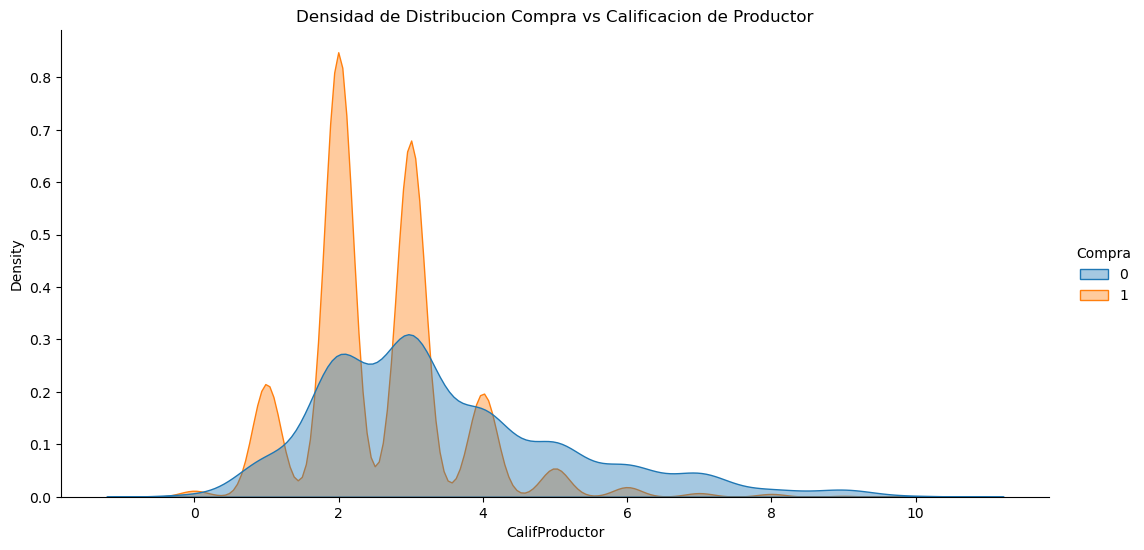

<Figure size 1400x400 with 0 Axes>

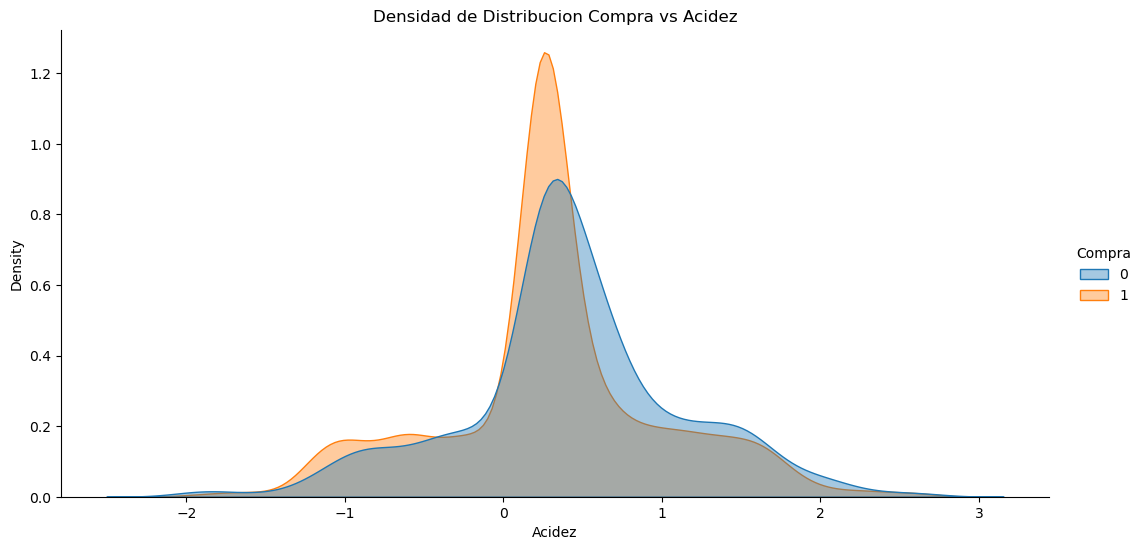

<Figure size 1400x400 with 0 Axes>

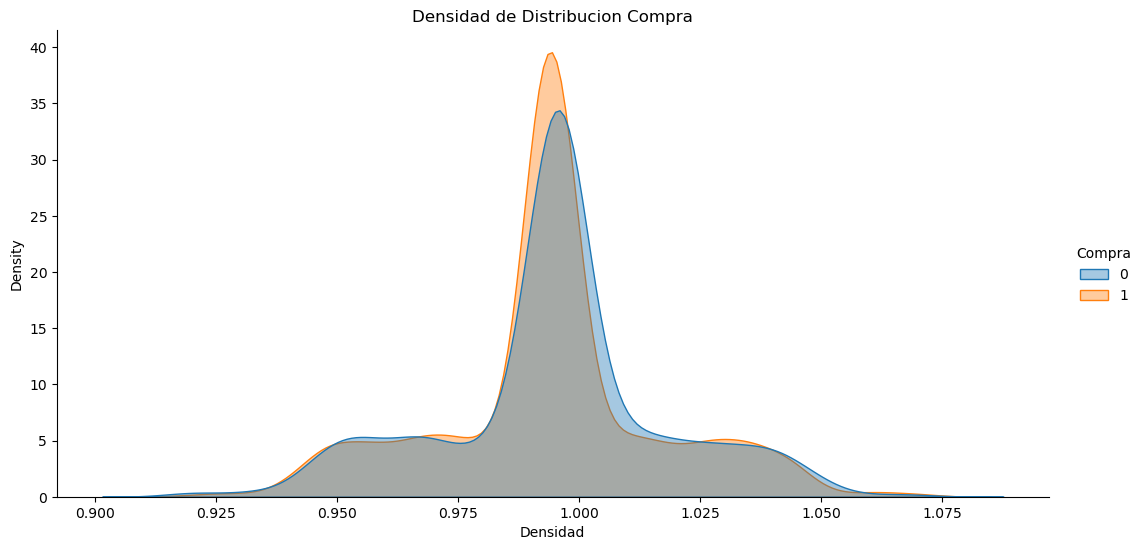

In [113]:
plt.rcParams['figure.figsize'] = [14, 4]  
plt.clf()

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.boxplot(x="Alcohol", y="Compra", data=datos_backup)
plt.title("Alcohol vs Compra")
plt.show()

plt.clf()
sns.boxplot(x="CalifProductor", y="Compra", data=datos_backup)
plt.title("Calificacion Producto vs Compra")
plt.show()

plt.clf()
sns.displot(datos_backup, x="CalifProductor", hue="Compra", kind='kde', fill=True, common_norm=False, alpha=0.4, height=5.4, aspect=2);
plt.title("Densidad de Distribucion Compra vs Calificacion de Productor")
plt.show()

plt.clf()
sns.displot(datos_backup, x="Acidez", hue="Compra", kind='kde', fill=True, common_norm=False, alpha=0.4, height=5.4, aspect=2);
plt.title("Densidad de Distribucion Compra vs Acidez")
plt.show()

plt.clf()
sns.displot(datos_backup, x="Densidad", hue="Compra", kind='kde', fill=True, common_norm=False, alpha=0.4, height=5.4, aspect=2);
plt.title("Densidad de Distribucion Compra") # Esto es inutil
plt.show()

En el caso de Acidez, existe una ligera diferencia en distribucion que quizá se traduzca en un mínimo efecto en el modelo <br>
Las variables de calificación del productor parecen tener influencia en el compra, en el sentido de que los vinos <br>
se compran (compra=1) tienen una distribución de calificación de productor menos elevada. Probablemente es porque sean mas caras <br>.

## Transformaciones de Variables
Vamos a generar las transformaciones de las variables continuas que maximizan la relación con la variable objetivo en sentido de V de Cramer <br>.
<br>

__Nota__: La principal precaución es que considerar un modelo completo con todas las variables al mismo tiempo pueden generar problemas de colinearlidad <br>
entre variables. Solamente utilizaremos el set completo de variables cuando hagamos un proceso de selección automática de variables, proceso en el cual se <br>
eligen variables que más R2 aporten al modelo.

In [116]:
transformacion_cramer = datos_backup.select_dtypes(include=np.number).apply(lambda x:mejorTransf(x, variable_objetivo, tipo="cramer"))
transformacion_cramer_nombres = datos_backup.select_dtypes(include=np.number).apply(lambda x:mejorTransf(x, variable_objetivo, tipo="cramer", name=True))
transformacion_cramer.columns = transformacion_cramer_nombres
transformacion_cramer

,Unnamed: 0_sqrt,ID_sqrt,Acidez_ident,AcidoCitrico_exp,Azucar_raiz4,CloruroSodico_ident,Densidad_raiz4,pH_sqr,Sulfatos_cuarta,Alcohol_sqr,CalifProductor_ident,PrecioBotella_log,Beneficio_sqrt,Aleatorio 1_sqrt,Aleatorio 2_exp
0,0.010000,0.010000,3.080819,6.258799,1.416638,1.666118,1.480495,12.094508,156.136064,9.253278,1.548025,-9.210340,1.292380,0.476520,9.548623
1,0.025382,0.023015,6.569486,5.721423,1.383030,3.246611,1.358495,9.358179,115.011549,40.620706,2.321987,0.475014,1.377409,1.280620,7.838150
2,0.034474,0.037270,3.263692,10.588711,1.403248,3.325294,1.360789,13.357686,293.145675,8.904141,2.321987,0.608537,0.010000,1.081118,11.065976
3,0.041626,0.045095,1.139544,27.352107,1.339708,3.256874,1.494893,10.162800,97.802762,11.293545,1.548025,1.262291,1.585379,1.692173,7.719978
4,0.047718,0.047418,3.235558,67.987613,1.371949,3.096088,1.362819,35.679446,82.601451,18.883869,0.774062,-0.027403,1.390298,1.215749,18.457417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6360,1.860505,1.860376,3.404364,21.994202,1.342751,3.458712,1.387574,24.272596,65.901981,8.060671,3.095950,-1.664586,0.010000,1.664401,4.853039
6361,1.860652,1.860433,3.826381,19.849598,1.490450,3.270558,1.356874,14.073131,138.169438,24.541338,1.548025,0.767919,1.695110,1.670410,27.394139
6362,1.860798,1.860491,3.319961,5.297692,1.156455,3.243190,1.251483,8.121435,90.654143,16.450002,3.095950,-0.602687,1.243789,1.429266,2.120084
6363,1.860944,1.861299,3.094886,4.314929,1.446934,3.386871,1.339266,10.682537,194.788880,12.697642,0.774062,-9.210340,1.411135,1.553136,13.422629


Aquí podemos fijarnos en los cambios de V de Cramer al transformar las variables. Destaca el caso de la variable Azucar. <br>
En su estado natural es muy mala, en cambio con la transformación raiz4 pasa directamente al top 5 de efectos, Esto es <br>
justamente lo que se busca con estas transformaciones.

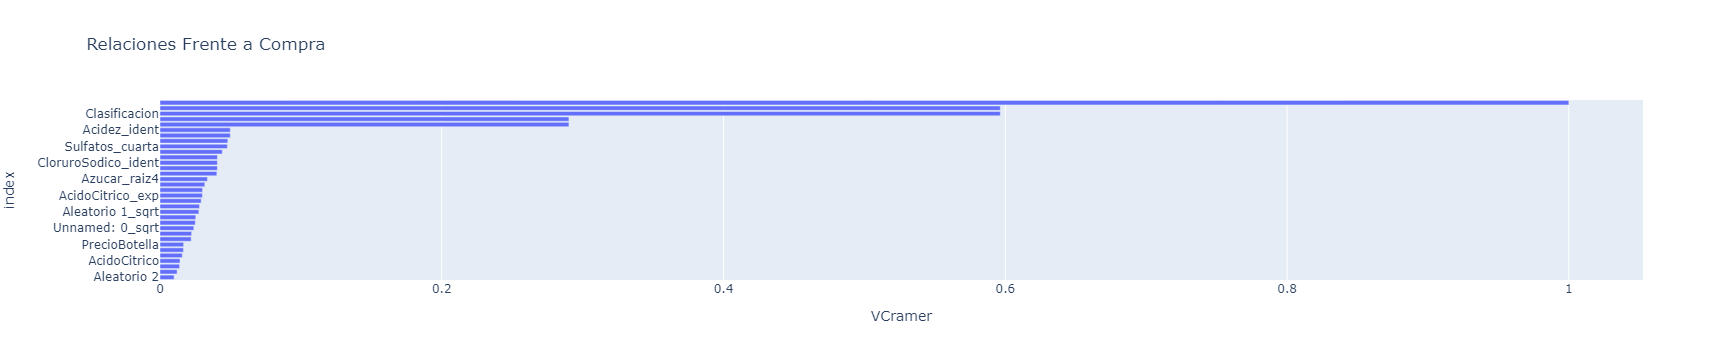

In [119]:
datos_transformados = datos_backup.join(transformacion_cramer)

# Aplicar la función al input completa contra la objetivo
datos_transformados = datos_transformados.drop(columns=["ID", "Compra", "Beneficio"])

tabla_cramer_transformaciones= pd.DataFrame(datos_transformados.apply(lambda x:cramers_v(x, variable_objetivo)), columns=["VCramer"])
px.bar(tabla_cramer_transformaciones, x=tabla_cramer_transformaciones["VCramer"], title="Relaciones Frente a Compra").update_yaxes(categoryorder="total ascending").show()

In [120]:
# Guardar archivo con transformaciones para la variable compra
# Agregar variables objetivo al input ya limpio
todo_bin = pd.concat([datos_transformados, variable_objetivo], axis=1)
todo_bin.to_csv("todo_bin_Vino.csv")


## Modelos de regresión logística para la predicción de variable compra
En esta sección se ajustan distintos modelos de regresión logística para predecir la compra de los vinos. En primer <br>
lugar, tomamos la partición training (donde ajustamos el modelo) y el test (donde lo probamos). <br>
<br>

Es importante revisar la distribución de la variable objetivo, cuantos 0s y 1s hay en el archivo <br>
esto es relevante a la hora de valorar cuestiones importantes en el contexto de clasificación supervisada. <br>
En particular prestamos atención a la baja representación del evento ya que esto supone un handicap para cualquier <br>
algoritmo de clasificación y ha dado lugar a toda una rama de investigación sobre __imbalanced classification__ que <br>
se agudiza en el contexto de Big Data y la paralelización de procesos con los llamados small disjunts. <br>
<br>
Es importante saber también cómo funcionana las métricas de evaluación en el contexto de la clasificación supervisada <br>
el famoso "accuracy", que deriva de la tasa de fallos de la matriz de confusión de las predicciones frente a la distribución original <br>
<br>
Es importante considerar el tradeoff entre sensibilidad y accuracy.

In [124]:
datos_backup["Compra"].value_counts(normalize=True)

Compra
1    0.785232
0    0.214768
Name: proportion, dtype: float64

En este caso, tenemos la situación de desbalanceo hacia los 1 ya que la frecuencia es de 78%. El modelo <br>
tendrá mayor dificultad para reconocer los 0s. Visto esto, si tenemos un accuracy de 0.78... podemos <br>
sospechar y miraremos bien sensibilidad y especificidad para tranquilizar nuestras conciencias.

## Paritción Training - Test
Vamos a generar la partición del archivo en el que incluiremos solamente las variables originales. Por ello, <br>
pedimos que nos muestre las posiciones de las variables para saber cómo filtrar las columnas deseadas.

In [137]:
from sklearn.model_selection import train_test_split
datos = datos.drop(['Unnamed: 0', 'prop_missings'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(datos, variable_objetivo, test_size=0.2, random_state=1)
print("Training data shape:", x_train.shape, y_train.shape) 

Training data shape: (5092, 16) (5092,)


¿ Mantendrá la proporción de clases de la variable objetivo esta partición?

In [140]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Compra
1    0.783975
0    0.216025
Name: proportion, dtype: float64
Compra
1    0.790259
0    0.209741
Name: proportion, dtype: float64


## Modelo Completo de Referencia
Comenzamos con nuestro modelo completo de referencia que incluye todas las variables. <br>
<br>
Una precaución en este punto. El método logit de statmodels.formula.api no acepta categórica <br>
cómo objetivo, por lo que transformaremos en entera.

In [148]:
formula_completa

'Compra ~ Acidez + AcidoCitrico + Azucar + CloruroSodico + Densidad + pH + Sulfatos + Alcohol + CalifProductor + PrecioBotella + Etiqueta + Clasificacion + Region + Clasificación + Aleatorio 1 + Aleatorio 2'

In [157]:
data_train = x_train.join(y_train.astype('int64'))
formula_completa = ols_formula(data_train, 'Compra')
# No admite variables categoricas
data_train[["Aleatorio 1", "Aleatorio 2"]] = data_train[["Aleatorio 1", "Aleatorio 2"]].astype('int64')

from statsmodels.formula.api import logit
# Por alguna razon no admite las variables aleatorias 1 y 2
modelo_completo = logit("Compra ~ Acidez + AcidoCitrico + Azucar + CloruroSodico + Densidad + pH + Sulfatos + Alcohol + CalifProductor + PrecioBotella + Etiqueta + Clasificacion + Region + Clasificación", data=data_train).fit()
modelo_completo.summary()

         Current function value: 0.301004
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5071
Method:                           MLE   Df Model:                           20
Date:                Sun, 04 Feb 2024   Pseudo R-squ.:                  0.4232
Time:                        12:00:48   Log-Likelihood:                -1532.7
converged:                      False   LL-Null:                       -2657.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.7506        nan        nan        nan         nan         nan
Etiqueta[T.M]            -0.3830      0.220     -1.743      0.081      -0.814       0.048
Etiqueta[T.R]            -1.0434      0.214     -4.867      0.000      -1.464      -0.623
Etiqueta[T.B]            -1.4818      0.230     -6.446      0.000      -1.932      -1.031
Etiqueta[T.MB]           -1.7445      0.351     -4.977      0.000      -2.432      -1.058
Clasificacion[T.**]      -0.7771        nan        nan        nan         nan         nan
Clasificacion[T.***]     10.7910   1.97e+12   5.47e-12      1.000   -3.87e+12    3.87e+12
Clasificacion[T.****]     8.5908   3.81e+11   2.25e-11      1.000   -7.47e+11    7.47e+11
Clasificacion[T.Desc]    -5.8084        nan        nan        nan         nan         nan
Region[T.2.0]            -0.0142      0.112     -0.127      0.899      -0.233       0.205
Region[T.3.0]            -0.0177      0.110     -0.162      0.872      -0.233       0.197
Clasificación[T.*]       -4.0456        nan        nan        nan         nan         nan
Clasificación[T.**]      -0.7771        nan        nan        nan         nan         nan
Clasificación[T.***]     10.7910   1.97e+12   5.47e-12      1.000   -3.87e+12    3.87e+12
Clasificación[T.****]     8.5908   3.81e+11   2.25e-11      1.000   -7.47e+11    7.47e+11
Acidez                   -0.1605      0.063     -2.550      0.011      -0.284      -0.037
AcidoCitrico              0.0850      0.058      1.456      0.145      -0.029       0.199
Azucar                    0.0027      0.001      1.854      0.064      -0.000       0.006
CloruroSodico            -0.2291      0.154     -1.488      0.137      -0.531       0.073
Densidad                 -0.2832      1.948     -0.145      0.884      -4.102       3.535
pH                       -0.2539      0.074     -3.453      0.001      -0.398      -0.110
Sulfatos                 -0.0728      0.055     -1.333      0.182      -0.180       0.034
Alcohol                  -0.0115      0.013     -0.882      0.378      -0.037       0.014
CalifProductor           -0.4259      0.035    -12.263      0.000      -0.494      -0.358
PrecioBotella             0.0291      0.030      0.966      0.334      -0.030       0.088
=========================================================================================

Possibly complete quasi-separation: A fraction 0.22 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [158]:
pd.crosstab(data_train["Compra"], data_train["Clasificacion"])

Clasificacion,*,**,***,****,Desc
Compra,,,,,
0,255,34,0,0,811
1,964,1355,874,261,538


Ni una sola instancia con compra=0 en clasificación de \*** y \**** <br> 
Esto genera ese alto error. El gran problema será la interpretabilidad del modelo. Hay que pense que el <br>
OR (cuanto más probable es que se de el evento que el no evento dada una premisa) es la exponencial del parámetro <br>
si este parámetro es 20, estamos ante un OR de  "485165195.4097903". Por este mótivo y dado que uno de los punto fuertes de <br>
las regresion es la interpretación, decidimos unir categorías.

In [161]:
np.exp(20)

485165195.4097903

In [168]:
datos["Clasificacion"] = datos["Clasificacion"].replace(["**", "***", "****"], "**+")

x_train, x_test, y_train, y_test = train_test_split(datos, variable_objetivo, test_size=0.2, random_state=1234)

data_train = x_train.join(y_train.astype('int64'))
data_test = x_test.join(y_test.astype('int64'))

modelo_completo = logit("Compra ~ Acidez + AcidoCitrico + Azucar + CloruroSodico + Densidad + pH + Sulfatos + Alcohol + CalifProductor + PrecioBotella + Etiqueta + Clasificacion + Region", data=data_train).fit()
modelo_completo.summary()

Optimization terminated successfully.
         Current function value: 0.306643
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5073
Method:                           MLE   Df Model:                           18
Date:                Sun, 04 Feb 2024   Pseudo R-squ.:                  0.4121
Time:                        12:29:48   Log-Likelihood:                -1561.4
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.1340      1.958      2.111      0.035       0.296       7.972
Etiqueta[T.M]            -0.3641      0.219     -1.664      0.096      -0.793       0.065
Etiqueta[T.R]            -1.0234      0.213     -4.798      0.000      -1.441      -0.605
Etiqueta[T.B]            -1.3882      0.228     -6.078      0.000      -1.836      -0.941
Etiqueta[T.MB]           -1.7858      0.331     -5.400      0.000      -2.434      -1.138
Clasificacion[T.**+]      3.0179      0.182     16.610      0.000       2.662       3.374
Clasificacion[T.Desc]    -1.8080      0.097    -18.651      0.000      -1.998      -1.618
Region[T.2.0]            -0.0996      0.111     -0.893      0.372      -0.318       0.119
Region[T.3.0]            -0.1208      0.110     -1.102      0.270      -0.336       0.094
Acidez                   -0.1597      0.064     -2.499      0.012      -0.285      -0.034
AcidoCitrico              0.0498      0.058      0.863      0.388      -0.063       0.163
Azucar                    0.0031      0.001      2.140      0.032       0.000       0.006
CloruroSodico            -0.2387      0.154     -1.551      0.121      -0.540       0.063
Densidad                  0.3074      1.929      0.159      0.873      -3.474       4.089
pH                       -0.2411      0.073     -3.322      0.001      -0.383      -0.099
Sulfatos                 -0.0739      0.054     -1.369      0.171      -0.180       0.032
Alcohol                  -0.0135      0.013     -1.049      0.294      -0.039       0.012
CalifProductor           -0.4201      0.035    -12.003      0.000      -0.489      -0.351
PrecioBotella             0.0297      0.030      0.985      0.325      -0.029       0.089
=========================================================================================
"""

Nos hemos librado de los peligros de OR gigantes <br>
<br>
Consultamos los valores de pseudor2 en los conjuntos de training y test, que se situan en torno a 0.41 <br>
lo cual indica un muy buen ajuste. Recordemos que puede equivaler a r2 lineales de más de 0.8.


In [169]:
import statsmodels.api as sm
import patsy 
from relativeImp import relativeImp

y_tr, x_tr = patsy.dmatrices("Compra ~ Acidez + AcidoCitrico + Azucar + CloruroSodico + Densidad + pH + Sulfatos + Alcohol + CalifProductor + PrecioBotella + Etiqueta + Clasificacion + Region", data_train, return_type='dataframe')
y_tst, x_tst = patsy.dmatrices("Compra ~ Acidez + AcidoCitrico + Azucar + CloruroSodico + Densidad + pH + Sulfatos + Alcohol + CalifProductor + PrecioBotella + Etiqueta + Clasificacion + Region", data_test, return_type='dataframe')

# Nombres de predictores donde quitamos la constante
names = x_tr.columns.tolist()[1:]

# Importancia relative
df_results = relativeImp(x_tr.join(y_tr), outcomeName= 'Compra', driverNames = names)

# Ordenamos valores
df_results.sort_values(by="normRelaImpt", ascending=False)


,driver,rawRelaImpt,normRelaImpt
5,Clasificacion[T.Desc],0.206834,51.611295
4,Clasificacion[T.**+],0.132229,32.995129
16,CalifProductor,0.046090,11.500807
2,Etiqueta[T.B],0.003786,0.944611
8,Acidez,0.002317,0.578132
1,Etiqueta[T.R],0.002272,0.566911
0,Etiqueta[T.M],0.001552,0.387299
3,Etiqueta[T.MB],0.001454,0.362817
13,pH,0.001009,0.251870
10,Azucar,0.000960,0.239518


## Métricas de ajuste en training-test
Sklearn para obtener todo tipo de métricas de evaluación para modelo logístico.

In [172]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# Definicion modelo
modelo = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='none')
variable_objetivo_training = y_tr["Compra"].ravel() ## ?? Investigar que hace esto

# Ajuste de Modelo
modelo_log = modelo.fit(x_tr, variable_objetivo_training)

# Especificidad
accuracy = modelo_log.score(x_tr, variable_objetivo_training)

# Predicciones en test
y_pred = modelo_log = modelo_log.predict(x_tst)

# Matriz de confusion
print(metrics.classification_report(y_tst, y_pred))


              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67       268
         1.0       0.91      0.91      0.91      1005

    accuracy                           0.86      1273
   macro avg       0.79      0.79      0.79      1273
weighted avg       0.86      0.86      0.86      1273



In [192]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from bioinfokit.visuz import stat

fpr, tpr, thresholds = roc_curve(y_tr, modelo.predict_proba(x_tr)[:, 1])
auc = roc_auc_score(y_tr, modelo.predict_proba(x_tr)[:, 1])
plt.clf()
stat.roc(fpr=fpr, tpr=tpr, auc=auc, shade_auc=True, per_class=True, legendpos='upper center', legendanchor=(0.5, 1.08), legendcols=3)
plt.show() # Doesn't display anything.

<Figure size 1400x400 with 0 Axes>

## Proceso manual hacia delante
Vamos a considerar con las 3 principales variables de acuerdo a su importancia relativa.

In [194]:
formula_condensada = "Compra ~ Clasificacion + CalifProductor + pH"
modelo1 = logit(formula_condensada, data=data_train).fit()
modelo1.summary()

Optimization terminated successfully.
         Current function value: 0.318111
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5087
Method:                           MLE   Df Model:                            4
Date:                Sun, 04 Feb 2024   Pseudo R-squ.:                  0.3901
Time:                        17:39:46   Log-Likelihood:                -1619.8
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.4223      0.273     12.545      0.000       2.888       3.957
Clasificacion[T.**+]      2.7876      0.178     15.654      0.000       2.439       3.137
Clasificacion[T.Desc]    -1.7679      0.094    -18.828      0.000      -1.952      -1.584
CalifProductor           -0.4376      0.034    -12.882      0.000      -0.504      -0.371
pH                       -0.2479      0.071     -3.492      0.000      -0.387      -0.109
=========================================================================================
"""

Este modelo es sencillo y bastante significativo en cuanto a sus parámetros. Por otr lado <br>
el pseudo R2 en training baja un poco pero aumento en test, lo que puede indicar mayor capacidad de <br>
generalización a datos desconocidos. <br>
<br>
Probaremos la interacción entre variables, por si existe un comportamiento conjunto.

In [196]:
formula_interaccion = "Compra ~ Clasificacion*Etiqueta + CalifProductor + pH"
modelo2 = logit(formula_interaccion, data=data_train).fit()
modelo2.summary()

Optimization terminated successfully.
         Current function value: 0.303723
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5075
Method:                           MLE   Df Model:                           16
Date:                Sun, 04 Feb 2024   Pseudo R-squ.:                  0.4177
Time:                        17:43:03   Log-Likelihood:                -1546.6
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                4.0613      0.431      9.428      0.000       3.217       4.906
Clasificacion[T.**+]                     1.2071      1.076      1.122      0.262      -0.901       3.316
Clasificacion[T.Desc]                   -1.4790      0.418     -3.537      0.000      -2.299      -0.659
Etiqueta[T.M]                           -0.1397      0.372     -0.375      0.708      -0.870       0.590
Etiqueta[T.R]                           -0.8884      0.354     -2.511      0.012      -1.582      -0.195
Etiqueta[T.B]                           -0.9383      0.384     -2.443      0.015      -1.691      -0.186
Etiqueta[T.MB]                          -2.1540      0.566     -3.804      0.000      -3.264      -1.044
Clasificacion[T.**+]:Etiqueta[T.M]       0.2443      1.117      0.219      0.827      -1.945       2.433
Clasificacion[T.Desc]:Etiqueta[T.M]     -0.2339      0.458     -0.511      0.609      -1.131       0.663
Clasificacion[T.**+]:Etiqueta[T.R]       1.9591      1.112      1.762      0.078      -0.220       4.138
Clasificacion[T.Desc]:Etiqueta[T.R]     -0.2247      0.440     -0.510      0.610      -1.088       0.639
Clasificacion[T.**+]:Etiqueta[T.B]       2.5153      1.166      2.158      0.031       0.230       4.800
Clasificacion[T.Desc]:Etiqueta[T.B]     -0.9999      0.484     -2.064      0.039      -1.949      -0.050
Clasificacion[T.**+]:Etiqueta[T.MB]      3.7396      1.540      2.428      0.015       0.721       6.758
Clasificacion[T.Desc]:Etiqueta[T.MB]     0.2862      0.729      0.393      0.694      -1.142       1.714
CalifProductor                          -0.4231      0.035    -12.143      0.000      -0.491      -0.355
pH                                      -0.2512      0.073     -3.463      0.001      -0.393      -0.109
========================================================================================================
"""

- Vinos con clasificacion + 2 estrellas
1. Si la etiqueta es B, su coeficiente es de 3.509 con lo que la probabilidad de compra de este tipo de vinos es de 3.509 veces superior a aquellos vinos con clasificación 1 estrella y etiqueta B. 
2. Si etiqueta es M, su coeficiente será 3.69+0.77-2.29, es decir, betaClas2estr + betaEtiM + betaClas2estr:EtiM. <br>
Con lo que el efecto será exp(3.69 + 0.77 - 2.29)= exp(2.17), menor que el anterior. Así que la probabilidad de compra <br>
de un vino con clasificación 2 estrellas y etiqueta mala es exp(2.17) mayor que la de un vino con clasificación 1 <br>
estrella y etiqueta B.



Vamos a probar a eliminar esta interacción y poner en su lugar un par de variables continuas para obtener un modelo <br>
más sencillo y evaluar posteriormente si el aumento en complejidad resulta en un mejor modelo.

In [198]:
formula3 = "Compra ~ Clasificacion + CalifProductor + pH + Etiqueta"
modelo3 = logit(formula3, data=data_train).fit()
modelo3.summary()

Optimization terminated successfully.
         Current function value: 0.308603
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5083
Method:                           MLE   Df Model:                            8
Date:                Sun, 04 Feb 2024   Pseudo R-squ.:                  0.4083
Time:                        17:52:21   Log-Likelihood:                -1571.4
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.2454      0.343     12.363      0.000       3.572       4.918
Clasificacion[T.**+]      3.0262      0.181     16.681      0.000       2.671       3.382
Clasificacion[T.Desc]    -1.7971      0.096    -18.656      0.000      -1.986      -1.608
Etiqueta[T.M]            -0.3534      0.218     -1.622      0.105      -0.780       0.074
Etiqueta[T.R]            -1.0111      0.212     -4.765      0.000      -1.427      -0.595
Etiqueta[T.B]            -1.3757      0.227     -6.049      0.000      -1.821      -0.930
Etiqueta[T.MB]           -1.7526      0.329     -5.319      0.000      -2.398      -1.107
CalifProductor           -0.4274      0.035    -12.343      0.000      -0.495      -0.360
pH                       -0.2485      0.072     -3.446      0.001      -0.390      -0.107
=========================================================================================
"""

El modelo tiene la mitad de parámetros que el anterior y su capcidad en el esquema training/test es muy parecida. <br>
<br>
Vamos a introducir otro par de variables continuas de las que pueden influir para valorar el aporte a la capacidad <br>
predictiva del modelo y su significancia estadística.

In [199]:
formula4 = "Compra ~ Clasificacion + CalifProductor + pH + Etiqueta + CloruroSodico"
# Ajustar modelo 1
modelo4 = logit(formula4, data=data_train).fit()
modelo4.summary()

Optimization terminated successfully.
         Current function value: 0.308374
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5082
Method:                           MLE   Df Model:                            9
Date:                Sun, 04 Feb 2024   Pseudo R-squ.:                  0.4088
Time:                        17:54:37   Log-Likelihood:                -1570.2
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.2501      0.343     12.386      0.000       3.578       4.923
Clasificacion[T.**+]      3.0251      0.181     16.672      0.000       2.669       3.381
Clasificacion[T.Desc]    -1.7969      0.096    -18.648      0.000      -1.986      -1.608
Etiqueta[T.M]            -0.3495      0.218     -1.605      0.109      -0.776       0.077
Etiqueta[T.R]            -1.0039      0.212     -4.731      0.000      -1.420      -0.588
Etiqueta[T.B]            -1.3693      0.227     -6.022      0.000      -1.815      -0.924
Etiqueta[T.MB]           -1.7472      0.330     -5.299      0.000      -2.394      -1.101
CalifProductor           -0.4255      0.035    -12.280      0.000      -0.493      -0.358
pH                       -0.2494      0.072     -3.459      0.001      -0.391      -0.108
CloruroSodico            -0.2336      0.153     -1.529      0.126      -0.533       0.066
=========================================================================================
"""

No tiene significacia estadistica y no aumenta el pseudo r cuadrado.

## Evaluación de los modelos por validación cruzada repetida
Partiremos la data en 5 partes formaremos 5 training con las 5 combinaciones de 4/5 <br>
con sus correspondientes 5 test de 1/5, repitiendo esto 20 veces con distintas semillas <br>
de inicialización. De esta forma, el modelo se enfrentará a distintos training y test sets <br>
considerando en su entranamiento todos los datos pero nunca todos a la vez, evitando <br>
sobreajuste. Tendremos 100 ajustes por fórmula y promediaremos los resultados obtenidos para <br>
valorar la relación sesgo-varianza.
<br>
<br> 
Utilizaremos la métrica ROC para evaluar la bondad de ajusta y no la especificidad.

In [207]:
def cross_val_log(formula, data, seed=1):
    y, x = patsy.dmatrices(formula, data, return_type='dataframe')
    y = y.iloc[:, 0].ravel()
    
    model = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='none')
    # Establecemos esquema de validacion fijando random_state (reproducibilidad)
    cv = RepeatedKFold(n_splits=5, n_repeats=20, random_state=seed)
    
    # Obtenemos los resultados de R2 para cada particion de training y test
    scores = cross_val_score(model, x, y, scoring='roc_auc', cv=cv)
    
    # Sesgo y varianza
    print("Modelo: " + formula)
    print("AUC: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))
    
    return scores

In [208]:
# Sklearn y sus mamadas
datos_backup["Compra"].astype("int64")

# Aplicacion a una formula
cross_val_log(formula4, data=datos_backup)

Modelo: Compra ~ Clasificacion + CalifProductor + pH + Etiqueta + CloruroSodico
AUC: 0.908 (0.008)


array([0.90766264, 0.91342125, 0.91176881, 0.90582721, 0.90093781,
       0.90899026, 0.90961492, 0.90162298, 0.90996937, 0.90651747,
       0.91818208, 0.89253395, 0.89983775, 0.90813698, 0.91777679,
       0.91954666, 0.90487189, 0.9055209 , 0.9096696 , 0.89998378,
       0.89177523, 0.90552756, 0.9102138 , 0.90965783, 0.92251659,
       0.91254197, 0.90035871, 0.91818534, 0.89147769, 0.91603062,
       0.92324818, 0.90553197, 0.91007764, 0.89051858, 0.90937033,
       0.90386571, 0.91316145, 0.91111855, 0.91014193, 0.89944608,
       0.90959768, 0.90577252, 0.9023425 , 0.91645869, 0.90347718,
       0.9135704 , 0.90580799, 0.90444971, 0.9036507 , 0.91150899,
       0.91609199, 0.90569033, 0.89643587, 0.91277419, 0.90598922,
       0.90912459, 0.90560264, 0.89626374, 0.92546196, 0.90343067,
       0.90203536, 0.89759816, 0.9215132 , 0.91311285, 0.90326471,
       0.91083085, 0.90897407, 0.90172913, 0.90924264, 0.90838594,
       0.91659076, 0.89358972, 0.9230388 , 0.90078436, 0.90457

Creamos lista de fórmula y aplicamos de forma general la comparativa por CV.

In [216]:
list_form = [formula_condensada, formula3, formula4]
list_res = pd.DataFrame(map(lambda x: cross_val_log(x, datos_backup, seed=2022), list_form))

Modelo: Compra ~ Clasificacion + CalifProductor + pH
AUC: 0.901 (0.007)
Modelo: Compra ~ Clasificacion + CalifProductor + pH + Etiqueta
AUC: 0.908 (0.007)
Modelo: Compra ~ Clasificacion + CalifProductor + pH + Etiqueta + CloruroSodico
AUC: 0.908 (0.007)


In [217]:
results = list_res.T.melt()
results.columns = ["Modelo", "AUC"]
results.head()

,Modelo,AUC
0,0,0.897092
1,0,0.897023
2,0,0.905656
3,0,0.899847
4,0,0.903244


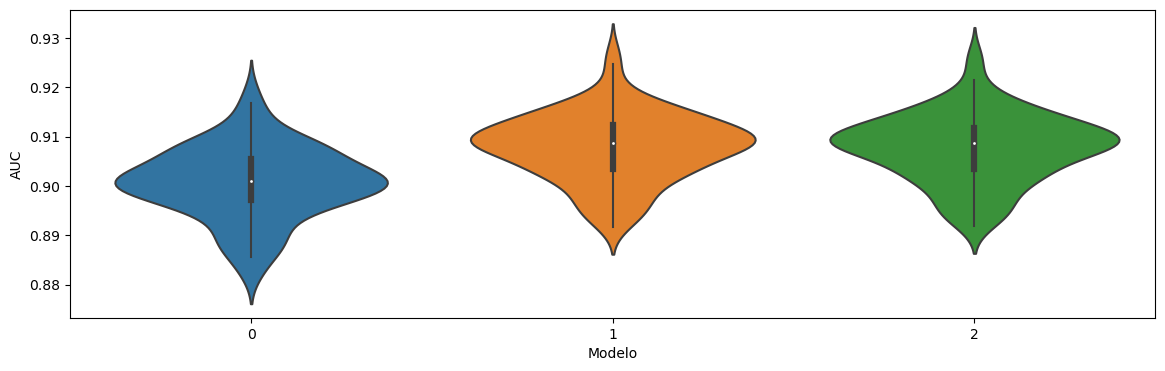

In [219]:
plt.clf()
sns.violinplot(x="Modelo", y="AUC", data=results)
plt.show()

## Punto de corte óptimo para la probabilidad estimada

Vamos a ver las distribuciones de las probabilidades estimadas para los conjuntos de evento y no evento observado <br>
Lo que nos gustaría tener es una separabilidad total, es decir 0 solapamiento e, idealmente que, las probabilidades <br>
estimadas para los 0 fueran muy bajas y las de los 1 contrariamente en valores altos cercanos a 1.

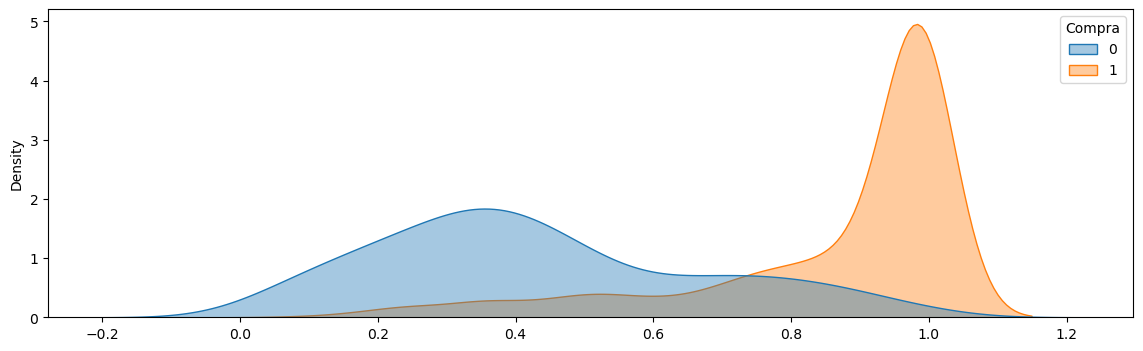

In [221]:
metrics.get_scorer_names() # Metricas
y_pred = modelo3.predict(x_test)
plt.clf()
sns.kdeplot(x=y_pred, hue=y_test, fill=True, common_norm=False, alpha=0.4)
plt.show()

En naranja la distribución de probabilidades estimadas para los 1. se ve bien, su densidad se "apunta" en valores altos. Sin embargo <br>
la de los 0 está mucho más repartida... Recordemos que dado el desbalanceo ya intuíamos que el modelo tendría mayor dificultad en <br>
reconocer los 0s. <br> 

En cualquier caso parece que se puede conseguir una separabilidad alta entre clases con algún punto de corte de la probabilidad, esto es <br>
diciendo todas las probabilidades estimadas mayor que punto de corto los clasifico como 1 y el resto como 0. <br>
<br>

El valor de corte por defecto en cualquier modelo de clasificación es el de 0.5 pero esto no es necesariamente lo más adecuado en contexto de <br>
desbalanceo. Por esta razón es bueno hacer el ejercicio de buscar el punto de corte que resulte óptimo bajo algún criterio.<br>
<br>
En primer lugar podemos ver que un valor de 0.75 haría una buena discriminación pero despues de ahí la densidad del valor 1 aumenta mucho. Probaremos <br>
ahí (siempre hay que tener en cuenta la prevalencia a priori del evento, es decir su **frecuencia relativa de aparición en el archivo era de 0.78**.

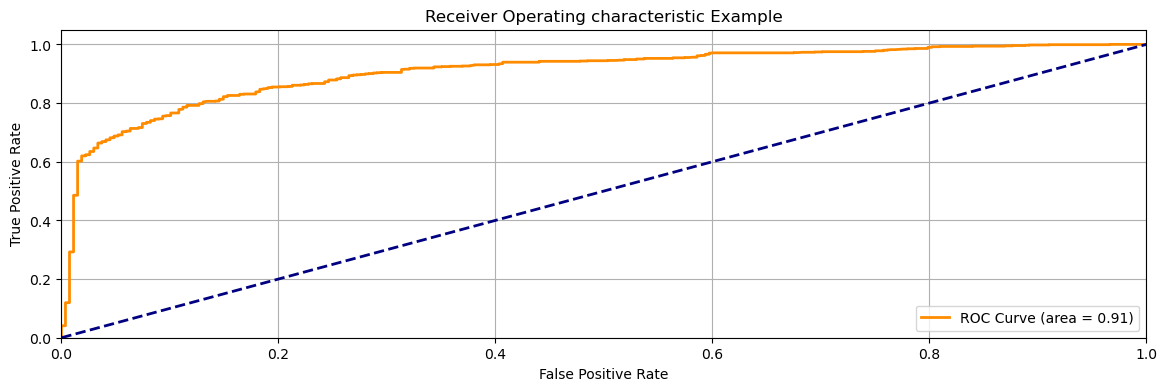

In [224]:
def roc_grafico(test, pred):
    fpr, tpr, thresholds = metrics.roc_curve(test, pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label="ROC Curve (area = %0.2f)" % roc_auc,)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating characteristic Example")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    
roc_grafico(y_test, y_pred)

Existe el índice de youden que maximiza la relación entre sensibilidad y especificidad conjuntamente con una formula aditiva. <br>

Podemos generar una rejilla de puntos de corte posibles entre 0 y 1 y valorar cual de estos maximiza este criterio y compararlo con el que maximiza el accuracy

In [231]:
def cutoff_youden(test,pred):
    fpr, tpr, thresholds = metrics.roc_curve(test,pred)
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

corte = cutoff_youden(y_test, y_pred)
corte

0.7621240299972789

Youden dice que el punto de corte óptimo es 0.76. Por otro lado y como es de esperar pues por definición, el punto de corte <br>
que maximiza el accuracy es 0.49. Probamos las métricas con estos valor. Veamos los coeficientes del modelo ganador.

In [232]:
modelo3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5083
Method:                           MLE   Df Model:                            8
Date:                Tue, 06 Feb 2024   Pseudo R-squ.:                  0.4083
Time:                        17:09:22   Log-Likelihood:                -1571.4
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.2454      0.343     12.363      0.000       3.572       4.918
Clasificacion[T.**+]      3.0262      0.181     16.681      0.000       2.671       3.382
Clasificacion[T.Desc]    -1.7971      0.096    -18.656      0.000      -1.986      -1.608
Etiqueta[T.M]            -0.3534      0.218     -1.622      0.105      -0.780       0.074
Etiqueta[T.R]            -1.0111      0.212     -4.765      0.000      -1.427      -0.595
Etiqueta[T.B]            -1.3757      0.227     -6.049      0.000      -1.821      -0.930
Etiqueta[T.MB]           -1.7526      0.329     -5.319      0.000      -2.398      -1.107
CalifProductor           -0.4274      0.035    -12.343      0.000      -0.495      -0.360
pH                       -0.2485      0.072     -3.446      0.001      -0.390      -0.107
=========================================================================================
"""

Influencia positiva de las clasificaciones buenas y las etiquetas y clasificación del productor <br>
malas/bajas. Influencia negativa de las dos continuas. <br>
<br>
Podemos ver la matriz de confusión en el conjunto de test. Para ello generaremos el factor de <br>
predicciones cortando las probabilidades estimadas por el punto de corte seleccionando y asignando 0 y 1,<br>
luego enfrentaremos a la verdad verdadero y evaluaremos su capacidad.

## Matrices de confusion
Comparemos matrices de confusión con punto de corte por defecto 0.5 y punto de corte <br>
Youden.

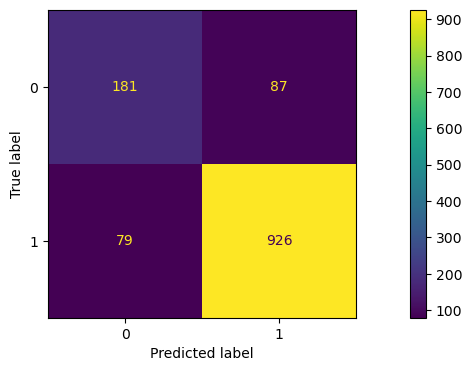

In [240]:
# Matriz de confusion 0.5
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = modelo2.predict(x_test)
matriz_confusion = confusion_matrix(y_test, round(y_pred))

cm_display = ConfusionMatrixDisplay(matriz_confusion).plot()
cm_display
plt.show()

In [242]:
print(metrics.classification_report(y_test, round(y_pred)))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       268
           1       0.91      0.92      0.92      1005

    accuracy                           0.87      1273
   macro avg       0.81      0.80      0.80      1273
weighted avg       0.87      0.87      0.87      1273



- Precision: Indica la proporción de identificaciones postivas que fueron realmente <br>
correctas. Para la clase 0, el modelo tiene una precisión del 70%, lo que significa <br>
que todas las instancias que el modelo predijo como clase 0, el 70% de ellas son <br>
realmente clase 0. Para la clase 1, la precisión es del 91%. <br>
<br>
- Recall (Sensibilidad o Exhaustividad) Muestra la propoción de positivos reales que <br>
fueron identificados correctamente. Para la clase 0, es del 68%, lo que significa que <br>
el modelo identificó correctamente el 68% de todas las instancias reales de la clase 0. <br>
para la clase 1, el valor es del 92%.
- F1-score: Es la media armónica de precisión y sensibilidad, que tiene en cuenta tanto <br>
los falsos positivos como los falsos negativos. Para la clase 0, es 0.69, lo que sugiere <br>
un balance razonable entre precisión y sensibilidad. Para la clase 1, es 0.92, lo que indica <br>
un buen balance.<br>
<br>
- Support: El número de ocurrencias reales de cada clase en tu conjunto de datos. Hay <br>
268 instancias de la clase 0 y 1005 de la clase 1.<br>
<br>
- Accuracy: La proporción de predicciones correctas entre el total de casos. Tu modelo <br>
tiene una exactitud del 87%, lo que significa que acierta en el 87% de las veces al predecir <br>
la clase correcta. <br>
<br>
- Macro Average: Es el promedio de la precisión, sensibilidad y F1-score para cada clase, sin <br>
tener en cuenta la proporción (support) de cada clase.